Visualizing sleep with DBSCAN and KMEANS
====================
This notebook visualizes sleep clusters using DBSCAN and KMEANS from the scikit-learn library.

Use of DBSCAN
-----------------------
DBSCAN is used to identify clusters of sleep periods in the data.

1. Get Series of start-sleep and end-sleep timings in radian from *get_x_from_df()*. In This method, time in the format of _HH:MM_ is converted into radian using the _convert_to_radian()_ method.

2. Create a new dataframe containing the radian values of start-sleep and end-sleep from (1)

3. Calculate the eps and minPts – parameters used for DBSCAN – using the *knee_calculate_eps_minPts* method from eps_min_pts.py

4. Create a pairwise distance matrix using from the dataframe in (2)

5. Call the _dbscan()_ method with the following parameters: eps, min_pts, X. eps and minPts are calculated in (3) and X is your pairwise distance matrix. Metric has been set to 'precomputed' as the pairwise distance matrix has been generated from (4)

This process will return you the following variables: *labels_, components_, core_sample_indices_*. *labels_* refer to the cluster label of each data point, i.e which cluster do they belong to. Values can be from 0 to n where n refers to the total number of clusters. Noise points are indicated with -1.

Use of KMeans
--------------------
KMEANS is used in the attempt of trying to partition an individual's day into day and night periods by attempting to cluster valid sleep clusters produced by DBSCAN using *k=2*

1. Create kmeans estimator using the following parameters KMeans(n_clusters=2,max_iter=1000, init='k-means++', precompute_distances='auto', n_jobs=-1)
    + n_clusters = 2, we attempt to partition the day into two parts.
    + max_iter=1000, as KMeans is a heuristic, we seek to improve the results by increasing the number of iterations.
    + init='k-means++', this is one of the modes provided by the KMeans library. This means that centroids are identified first prior to the algorithm. Results in better performance.
    + precompute_distanes='auto', Results in faster run time.
    + n_jobs = -1, specifies that all cores be used.
2. Create a new dataframe consisting of all valid sleep clusters identified by the DBSCAN algorithm.
3. Fit the dataframe to the KMeans estimator.
4. Get *cluster_centers_, km.labels_, km.inertia_* from the estimator to use for plotting.
5. To get the extent (earliest start-sleep and latest end-sleep timings), we extract the min(start-sleep) and max(end-sleep) timing from each cluster.



In [37]:
%matplotlib inline
###########################################IMPRORTS#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from math import pi,sqrt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import DistanceMetric
import eps_min_pts as eps_And_MinPts
import helper_adl as h
from matplotlib.backends.backend_pdf import PdfPages
###########################################IMPRORTS#########################################


# To return value in mins / total mins in one day
def to_mins(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return (x.value - pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day)).value) / (60 * (10**9))
def to_date(x):
    x = pd.Timestamp(x)
    year = x.year
    month =  x.month
    day = x.day
    return pd.Timestamp(str(year)+'-'+str(month)+'-'+str(day))
# Helper method to convert values to radian
def convert_to_radian(x):
    return ((x / (24*60)) * 2 * pi)

# Returns a distance matrix (a numpy array)
def get_x_from_df(series):
    
    # Vectorizing to_mins and to_radian functions
    tmin = np.vectorize(to_mins)
    trad = np.vectorize(convert_to_radian)

    # Converting series of timestamp -> minutes / total minuites in a day -> radian
    input_rad = trad(tmin(series))
    #print("0, the raw array  is {}".format(input_rad))
    # Convert time to rad points   
    X = input_rad[None,:] - input_rad[:,None]
    print("the raw matix size is {}".format(X.size))
    print("the raw matix shape is {}".format(X.shape))
    #print("1, the raw matix  is {}".format(X))
    # Assign 'shortest distance to each point
    X[((X > pi) & (X <= (2*pi)))] = X[((X > pi) & (X <= (2*pi)))] -(2*pi)
    X[((X > (-2*pi)) & (X <= (-1*pi)))] = X[((X > (-2*pi)) & (X <= (-1*pi)))] + (2*pi) 
    X = abs(X)
    #print("2, the processed matix  is {}".format(X))
    return X,input_rad

# Returns output from sklearn DBSCAN method
def dbscan(eps, min_pts, X, metric='precomputed'):
    db = DBSCAN(eps, min_pts, metric)
    db.fit(X)
    return db.labels_, db.components_, db.core_sample_indices_

# Configures polar plot with 24 hour tick labels
def configure_polar_plot(axes):
    xticklabels = [str(x) for x in range (0,24)]
    axes.set_xticks(np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi))
    axes.set_xticklabels(xticklabels)
    axes.set_theta_zero_location('N')
    axes.set_theta_direction(-1)
    axes.set_ylim([0,1])
    axes.set_yticks([0.8,0.6])
    axes.set_yticklabels(['Sleep-Start', 'Sleep-End'])
    
    return axes

def plot_clusters(labels, rad_tseries, axes, ring):
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k,col in zip(unique_labels, colors):
        marker = '.'
        ms = 25.0
        rate = (1+k*0.1)*ring
        if k == -1:
            col='k'
            marker = 'x'
            ms = 8.0
            rate = ring

        indices_of_k, = np.where(labels == k)
        data = rad_tseries.take(indices_of_k)
        #print("ring is {},lable is {},data is {}".format(ring,k,data))
        
        axes.plot(data, [rate for x in data], color=col, marker=marker, linestyle='none', ms=ms, mec='k')

def get_clusters_info(label,rad_series,eps):
    for cluster_i in set(label):
        if cluster_i!=-1:
            print(cluster_i)
            indices_of_k = np.where(label == cluster_i)
            data = rad_series.take(indices_of_k)
            #print(data)
            data_min = np.min(data)
            #print(data_min)
            data_max = np.max(data)
            if data_max > pi and data_min<pi:
                data_min_ = np.min(data[data>pi])
                data_max_ = np.max(data[data<pi])
                if (data_min_ - data_max_) > eps:
                    data_max = np.max(data[data<pi])
                    data_min = np.min(data[data>pi])
            date_min = pd.to_datetime(data_min/2/pi*(24*60)*(60*10**9))
            date_max = pd.to_datetime(data_max/2/pi*(24*60)*(60*10**9))
            print("Cluster {}, start time:{}".format(cluster_i,date_min.strftime("%H:%M:%S")))
            print("Cluster {}, end time:{}".format(cluster_i,date_max.strftime("%H:%M:%S")))
 
# customize the distance calculations 
def customized_kmean_function(x,y):
    distance_temp = np.abs(x-y)
    distance_temp[distance_temp>pi]=2*pi - distance_temp[distance_temp>pi]
    return np.sqrt(np.sum(distance_temp**2))

File name:  ../Data/sleep/sleep_raw/sleep_S001_2015.csv
there are 264 start date
there are 272 end date
so we choose a half number 105 as the minPts
time_start: eps:  0.2617993877991494  minPts:  131

========Calulate For start time==========

the raw matix size is 693889
the raw matix shape is (833, 833)
{0, -1}
0
Cluster 0, start time:18:31:43
Cluster 0, end time:22:02:40
Number of clusters for start sleep time:  1



========Calulate For end time==========

the raw matix size is 693889
the raw matix shape is (833, 833)
time_end: eps:  0.2617993877991494  minPts:  131
{0, 1, -1}
0
Cluster 0, start time:03:05:09
Cluster 0, end time:06:45:02
1
Cluster 1, start time:06:48:19
Cluster 1, end time:09:58:17
Number of clusters for end sleep time:  2


duration: eps:  0.2617993877991494  minPts:  131
Number of clusters for X3(pairwise) cluster:  0


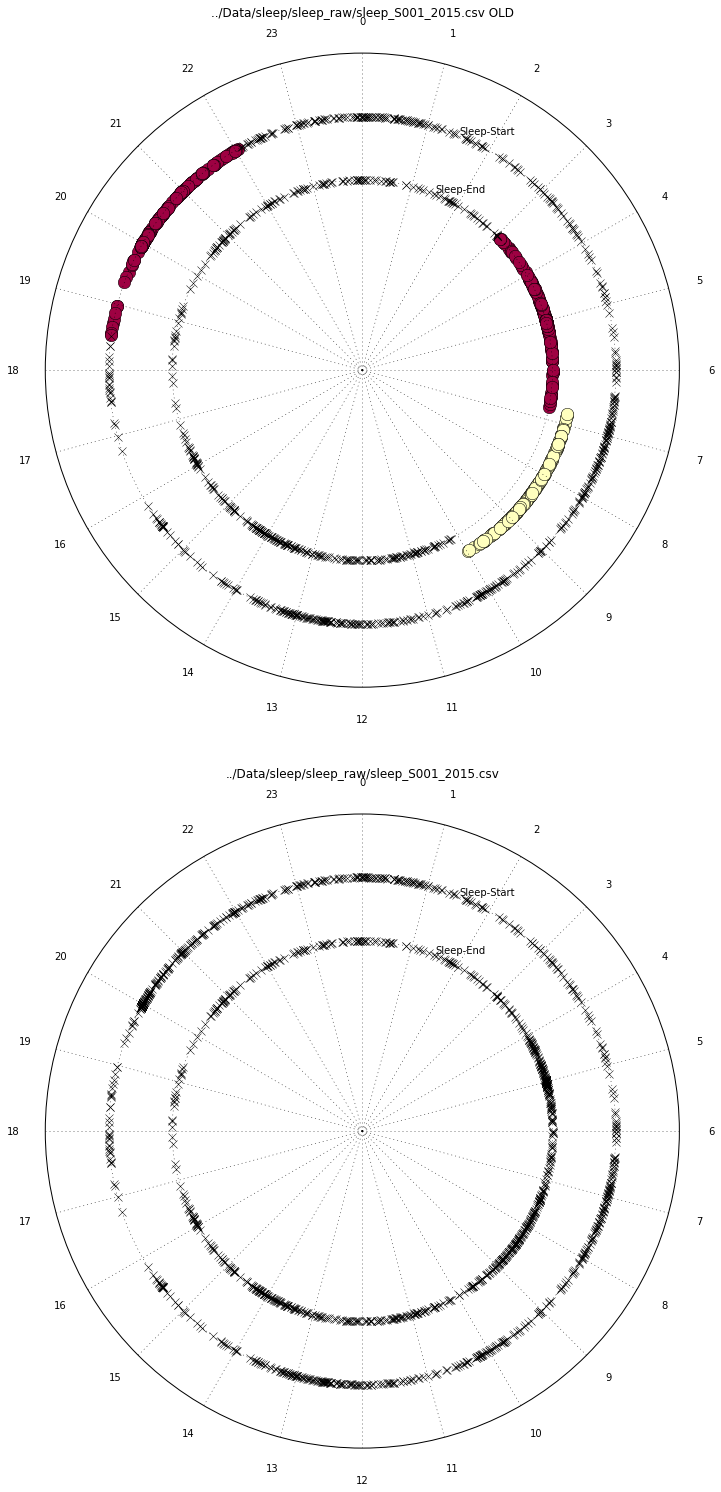

Elasped Time:  5.982 seconds


In [47]:

# Code
# Start timer:
time_now = time.time()

### Globals ###
file_dir = '../Data/sleep/sleep_raw'
# Perform clustering on files 1 to 10
# indexes = [str(x) for x in range(1,10)]
index = '9'
#sleep/sleep-aggregate_2016-01_S042.csv
file_name = ''.join([file_dir,'/','sleep_S001_2015.csv'])


# print file name
print('File name: ', file_name)




# Get dataframe containing readings from sensor reading, exclude 
df = pd.read_csv(file_name, delimiter=',', usecols=[x for x in range(1,7)],parse_dates=[1])
column_names = list(df.columns.values)



start_day_list = pd.to_datetime(df['time_start']).apply(lambda x: x.strftime("%Y-%m-%d"))
end_day_list = pd.to_datetime(df['time_end']).apply(lambda x: x.strftime("%Y-%m-%d"))
print("there are {} start date".format(len(sorted(set(start_day_list)))))
print("there are {} end date".format(len(sorted(set(end_day_list)))))
min_pts = int(len(set(start_day_list) & set(end_day_list))/2)
eps =2*pi/24
print("so we choose a half number {} as the minPts".format(minPts))

print('time_start: eps: ', eps , ' minPts: ' , min_pts)


# X is a distance matrix.
# Set 'X1' as sleep_start timings
print("\n========Calulate For start time==========\n")
X1,X1_rad_series = get_x_from_df(df['time_start'])




#eps_X1, min_pts_X1 = eps_And_MinPts.knee_calculate_eps_minPts(X1)
#print('time_start: eps: ', eps_X1 , ' minPts: ' , min_pts_X1)
# sk-learn dbscan
X1_label, X1_components, X1_csi = dbscan(eps, min_pts, X1)
# - 1 if -1 exist in labels because -1 is used to denote noise
#print("X1 is {}".format(X1))
#print("X1 shape is {}".format(X1.shape))
#print("X1_label is {}".format(X1_label))
#print("X1_label lengh is {}".format(len(X1_label)))
#print("X1_components is {}".format(X1_components))
#print("X1_components shape is {}".format(X1_components.shape))
#print("X1_csi is {}".format(X1_csi))
#print("X1_csi lengh is {}".format(len(X1_csi)))
print(set(X1_label))
get_clusters_info(X1_label,X1_rad_series,eps_X1)

    
X1_no_clusters = len(set(X1_label)) - (1 if -1 in X1_label else 0)
print('Number of clusters for start sleep time: ', X1_no_clusters )
indices_of_X1_without_noise, = np.where(X1_label != -1)
# print(indices_of_X1_without_noise)
X1_no_noise = X1_rad_series[indices_of_X1_without_noise]
print("\n")

print("\n========Calulate For end time==========\n")
# Set 'X2' as sleep_end timings
X2,X2_rad_series = get_x_from_df(df['time_end'])
#eps_X2, min_pts_X2 = eps_And_MinPts.knee_calculate_eps_minPts(X2)
print('time_end: eps: ', eps , ' minPts: ' , min_pts)
# sk-learn dbscan
X2_label, X2_components, X2_csi = dbscan(eps, min_pts, X2)
# - 1 if -1 exist in labels because -1 is used to denote noise
#print("X2 is {}".format(X2))
#print("X2 shape is {}".format(X2.shape))
#print("X2_label is {}".format(X2_label))
#print("X2_label lengh is {}".format(len(X2_label)))
#print("X2_components is {}".format(X2_components))
#print("X2_components shape is {}".format(X2_components.shape))
#print("X2_csi is {}".format(X1_csi))
#print("X2_csi lengh is {}".format(len(X1_csi)))
print(set(X2_label))

#print the clusters info
get_clusters_info(X2_label,X2_rad_series,eps_X2)

X2_no_clusters = len(set(X2_label)) - (1 if -1 in X2_label else 0)
print('Number of clusters for end sleep time: ', X2_no_clusters )
indices_of_X2_without_noise, = np.where(X2_label != -1)
# print(indices_of_X2_without_noise)
X2_no_noise = X2_rad_series[indices_of_X2_without_noise]
print("\n")
# Create X3 DataFrame from X to test pairwise clusters
# Data has already been optimized; Values are in radian, and shortest distances
# have been assigned.
X3 = pd.DataFrame()
X3['sleep_start'] = X1_rad_series
X3['sleep_end'] = X2_rad_series

# Calculate eps and minPts dynamically.
#print("X3 is {}".format(X3))
distance = DistanceMetric.get_metric('euclidean')
X3_dist_matrix = distance.pairwise(X3)
#print("the old X3_dist_matrix is {}".format(X3_dist_matrix))

distance = DistanceMetric.get_metric('pyfunc',func=customized_kmean_function)

X3_dist_matrix = distance.pairwise(X3)
#print("the new X3_dist_matrix is {}".format(X3_dist_matrix))
#print("the X3 is {}".format(X3))
#print("the X3_dist_matrix is {}".format(X3_dist_matrix))
#eps_X3, min_pts_X3 = eps_And_MinPts.knee_calculate_eps_minPts(X3_dist_matrix)
print('duration: eps: ', eps , ' minPts: ' , min_pts)

# sk-learn dbscan
db3 = DBSCAN(eps, min_pts, metric='precomputed').fit(X3_dist_matrix)
X3_label, X3_components, X3_csi = db3.labels_, db3.components_, db3.core_sample_indices_

# Flatten X3 to a matrix to plot out values.
#print("X3 is {}".format(X3))
X3_matrix = X3.as_matrix()
#print("X3_matrix is {}".format(X3_matrix))
X3_matrix = X3_matrix.T
#print("new X3_matrix is {}".format(X3_matrix))
# - 1 if -1 exist in labels because -1 is used to denote noise
X3_no_clusters = len(set(X3_label)) - (1 if -1 in X3_label else 0)
print('Number of clusters for X3(pairwise) cluster: ', X3_no_clusters )

"""
# Remove noise, prep data for kmeans
indices_of_X3_without_noise, = np.where(X3_label != -1)
X3_no_noise = X3.ix[indices_of_X3_without_noise]
#print("X3_no_noise is {}".format(X3_no_noise))
# Config k-means estimator
km = KMeans(n_clusters=2,max_iter=1000, init='k-means++', precompute_distances='auto', n_jobs=-1)
# Performing fit..
#print(X3_no_noise)
km.fit(X3_no_noise)
XX_cluster_centers = km.cluster_centers_ 
XX_labels = km.labels_
XX_inertia = km.inertia_

#print("XX_cluster_centers is {}".format(XX_cluster_centers))
#print("XX_labels is {}".format(XX_labels))
#print("XX_inertia is {}".format(XX_inertia))

# Remove noise first

km_clusters = set(XX_labels)
km_dict = {}
print(km_clusters)
for k in km_clusters:
    indices_of_k, = np.where(XX_labels == k)
    print(indices_of_k)
    #################################################################
    ##  the logic here is incorrect ## 
    #################################################################
    X3_min = np.min(X3_no_noise['sleep_start'].ix[indices_of_k])
    X3_max = np.max(X3_no_noise['sleep_end'].ix[indices_of_k])
    # Check if min > max, swap  
    km_dict[k] = (X3_min, X3_max)
"""
##################PLOTTING####################
# TODO: CLUSTER
# TODO: CLUSTER
fig = plt.figure(figsize=(25,25))
# fig1 = plt.figure(figsize=(6,6))
ax1 = configure_polar_plot(fig.add_subplot(211, projection='polar'))
ax1.set_title(file_name + ' OLD')
# Plot clusters for start_time and end_time for sleep periods
plot_clusters(X1_label, X1_rad_series, ax1, 0.8)
plot_clusters(X2_label, X2_rad_series, ax1, 0.6)


ax2 = configure_polar_plot(fig.add_subplot(212, projection='polar'))
ax2.set_title(file_name)
# Plot clusters of pairwise start_time and end_time for sleep periods
plot_clusters(X3_label, X3_matrix[0], ax2, 0.8)
plot_clusters(X3_label, X3_matrix[1], ax2, 0.6)

"""

ax3 = fig.add_subplot(223)
ax3.set_title('K-means plot of Sleep periods')
ax3.set_xlabel('start-sleep time')
ax3.set_ylabel('end-sleep time')
xy_ticks = np.linspace(0,23,24,endpoint=True, dtype=np.int32) / 24 * (2 * np.pi)
xy_ticklabels = [str(x) for x in range (0,24)]
ax3.set_xticks(xy_ticks)
ax3.set_yticks(xy_ticks)
ax3.set_xticklabels(xy_ticklabels)
ax3.set_yticklabels(xy_ticklabels)




# Plot decision space

# Step size of the mesh. Decrease to increase the quality of the Vector Quantization.
stepsize = .02 # point in the mesh [x_min, m_max]x[y_min, y_max].

X3_as_matrix = X3_no_noise.as_matrix().T
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X3_as_matrix[0].min(), X3_as_matrix[0].max()
y_min, y_max = X3_as_matrix[1].min(), X3_as_matrix[1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, stepsize), np.arange(y_min, y_max, stepsize))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax3.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

ax3.scatter(X3_as_matrix[0], X3_as_matrix[1])
# Zoom in on identified cluster
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Handy dandy method to manage the width of the bar on the polar chart..
def get_bar_width(min, max):
    if min > max:
        return (h.convert_to_radian(1440)) - min + max
    else:
        return max - min

print(km_dict)
km_clust_0_min, km_clust_0_max = km_dict[0]
km_clust_1_min, km_clust_1_max = km_dict[1]
bar = ax2.bar(km_clust_0_min,0.5, width=get_bar_width(km_clust_0_min, km_clust_0_max), bottom=0.0, color='skyblue',)
bar2 = ax2.bar(km_clust_1_min,0.3, width=get_bar_width(km_clust_1_min, km_clust_1_max), bottom=0.0, color='peachpuff', alpha=0.5)


"""
plt.show()

print("Elasped Time: ", round(time.time() - time_now, 3), "seconds")

pdf = PdfPages("a.pdf")

# save plot using savefig() method of pdf object
pdf.savefig(fig)


# remember to close the object to ensure writing multiple plots
pdf.close()    

## 